In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import pickle
import numpy as np
import tensorflow as tf
old_v = tf.compat.v1.logging.get_verbosity()
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tensorflow.python.framework import ops
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.examples.tutorials.mnist import input_data

def get_session(gpu_fraction=0.5):
    num_threads = os.environ.get('OMP_NUM_THREADS')
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_fraction)
 
    if num_threads:
        return tf.Session(config=tf.ConfigProto(
            gpu_options=gpu_options, intra_op_parallelism_threads=num_threads))
    else:
        return tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
    
class Dataset:

    def getTask(self):
        return self.task

    def showSamples(self, nrows, ncols):
        """
        Plot nrows x ncols images
        """
        fig, axes = plt.subplots(nrows, ncols)
        for i, ax in enumerate(axes.flat): 
            ax.imshow(self.task['x_train'][i,:])
            ax.set_xticks([]); ax.set_yticks([])
            ax.set_title(np.argmax(self.task['y_train'][i]))
        
        plt.show()

        
class MNISTdata(Dataset):
    """
    MNIST dataset
    
    A large collection of monochrome images of handwritten digits
    
    It has a training set of 55,000 examples, and a test set of 10,000 examples
    """

    def __init__(self):
        mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
        x_train = np.reshape(mnist.train.images, [-1, 28, 28, 1])
        x_val = np.reshape(mnist.test.images, [-1, 28, 28, 1])
        x_train = np.concatenate([x_train, x_train, x_train], 3)
        x_val = np.concatenate([x_val, x_val, x_val], 3)
        
        print("MNIST : Training Set", x_train.shape)
        print("MNIST : Test Set", x_val.shape)
        
        # Calculate the total number of images
        num_images = x_train.shape[0] + x_val.shape[0]
        print("MNIST : Total Number of Images", num_images)
        
        self.task = {'name':'mnist', 'x_train':x_train, 'x_val':x_val, 'y_train':mnist.train.labels, 'y_val':mnist.test.labels}


class MNIST_Mdata(Dataset):
    """
    MNIST-M dataset
    
    This dataset is created by combining MNIST digits with the patches randomly extracted from color photos of BSDS500 as their background
    
    It contains 55,000 training and 10,000 test images as well
    """
    
    def __init__(self):
        mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
        mnistm = pickle.load(open('dataset/mnistm_data.pkl', 'rb'), encoding='latin1')

        x_train = np.reshape(mnistm['train'], [-1, 28, 28, 3])/255
        x_val = np.reshape(mnistm['test'], [-1, 28, 28, 3])/255
        
        print("MNIST-M : Training Set", x_train.shape)
        print("MNIST-M : Test Set", x_val.shape)

        # Calculate the total number of images
        num_images = x_train.shape[0] + x_val.shape[0]
        print("MNIST-M : Total Number of Images", num_images)
        
        self.task = {'name':"mnist-m", 'x_train':x_train, 'x_val':x_val, 'y_train':mnist.train.labels, 'y_val':mnist.test.labels}


class FlipGradientBuilder(object):
    """
    Gradient Reversal Layer (GRL)
    
    During the forward propagation, GRL acts as an identity transform
    
    During the backpropagation though, GRL takes the gradient from the subsequent level,
    multiplies it by -λ(learning rate) and pass it to the preceding layer
    """
    
    def __init__(self):
        self.num_calls = 0

    def __call__(self, x, learning_rate=1.0):
        
        grad_name = "FlipGradient%d" % self.num_calls
        
        @ops.RegisterGradient(grad_name)
        def _flip_gradients(op, grad):
            return [tf.negative(grad) * learning_rate]
        
        g = tf.get_default_graph()
        with g.gradient_override_map({"Identity": grad_name}):
            y = tf.identity(x) # copy for assign op
            
        self.num_calls += 1
        return y

class Model:
    """
    Creates a DANN model that will be trained on the MNIST (source) and MNIST-M (target) dataset
    """

    def __init__(self):
        self.build()

    def build(self):
        tf.reset_default_graph()
    
        Xs, Xt, Ys, Yt, D = create_placeholders(28, 28, 3, 10)
        l = tf.placeholder(tf.float32, [], name='l')        # Gradient reversal scaler
        params = initialize_parameters()
    
        self.Fs = forward_propagation(Xs, params, 'feature extractor')
        self.Ft = forward_propagation(Xt, params, 'feature extractor')
        self.F = tf.concat([self.Fs, self.Ft], axis=0)
        self.F_ = _flip_gradient(self.F, learning_rate=l)
    
        out_label = forward_propagation(self.Fs, params, 'label predictor')
        out_domain = forward_propagation(self.F_, params, 'domain classifier')

        self.L_label = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=out_label, labels=Ys))
        self.L_domain = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=out_domain, labels=D))
    
        self.L_final = tf.add(self.L_label, self.L_domain)

        self.label_train_op = tf.train.AdamOptimizer(learning_rate=0.001).minimize(self.L_label)
        self.domain_train_op = tf.train.AdamOptimizer(learning_rate=0.001).minimize(self.L_domain)
        self.final_train_op = tf.train.AdamOptimizer(learning_rate=0.001).minimize(self.L_final)

        y_hat = tf.argmax(tf.nn.softmax(out_label), 1)
        d_hat = tf.argmax(tf.nn.softmax(out_domain), 1)

        self.acc_label = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(Ys, 1), y_hat), tf.float32))
        self.acc_domain = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(D, 1), d_hat), tf.float32))
        
    def train(self, data_S, data_T, trainingMode, num_epochs=100, minibatch_size=500):
        seed = 9449
    
        if trainingMode == 'dann':
            minibatch_size = minibatch_size//2

        sess = tf.compat.v1.InteractiveSession()

        # Run the initialization
        sess.run(tf.compat.v1.global_variables_initializer())
            
        # Do the training loop
        for epoch in range(num_epochs):
            loss_f = 0.; loss_d = 0.; loss_p = 0.
            
            # number of minibatches of size minibatch_size in the train set
            # for the convenience, the size of the learning set and the verification set are the same.
            num_batches = int(data_S['x_train'].shape[0] / minibatch_size)
            seed = (seed + 2229)%3114
            
            batches_S = random_mini_batches(data_S['x_train'], data_S['y_train'],
                                            mini_batch_size=minibatch_size, seed=seed)
            batches_T = random_mini_batches(data_T['x_train'], data_T['y_train'],
                                            mini_batch_size=minibatch_size, seed=seed)
            
            for i, minibatch_S, minibatch_T in zip(range(num_batches), batches_S, batches_T):
                # Select a minibatch
                (X_s, Y_s) = minibatch_S
                (X_t, Y_t) = minibatch_T
                
                p = float(i) / num_batches
                #l_p = 2. / (1. + np.exp(-10. * p)) - 1
                l_p = 1.
                
                if trainingMode == 'source only' :
                    _, _loss_p = sess.run([self.label_train_op, self.L_label], 
                                          feed_dict={'Xs:0': X_s, 'Ys:0': Y_s})                
                    loss_p = loss_p + _loss_p / num_batches
                elif trainingMode == 'target only' :
                    _, _loss_p = sess.run([self.label_train_op, self.L_label], 
                                          feed_dict={'Xs:0': X_t, 'Ys:0': Y_t})                
                    loss_p = loss_p + _loss_p / num_batches
                elif trainingMode == 'dann' :
                    D_ = np.vstack([np.repeat([[1,0]], minibatch_size, axis=0), 
                                    np.repeat([[0,1]], minibatch_size, axis=0)])
            
                    _, _loss_f, _loss_d, _loss_p = sess.run([self.final_train_op, self.L_final, self.L_domain, self.L_label],
                                                        feed_dict={'Xs:0': X_s, 'Ys:0': Y_s, 'Xt:0': X_t, 'Yt:0': Y_t,
                                                                   'D:0': D_, 'l:0': l_p})
                    loss_f = loss_f + _loss_f / num_batches
                    loss_d = loss_d + _loss_d / num_batches
                    loss_p = loss_p + _loss_p / num_batches
                else :
                    print("You have passed a wrong argument\n",
                        "Training method should be one among 'source only', 'target only', 'dann'")
                    exit()
                    
            if (epoch + 1)%10 == 0 :      
                acc_ps, acc_ds = sess.run([self.acc_label, self.acc_domain],
                                    feed_dict={'Xs:0': data_S['x_val'], 'Ys:0': data_S['y_val'],
                                               'Xt:0': np.zeros(shape=(0,28,28,3), dtype=np.float32), 
                                               'Yt:0': np.zeros(shape=(0,10), dtype=np.float32),
                                               'D:0': np.repeat([[1,0]], data_S['x_val'].shape[0], axis=0)})
                acc_pt, acc_dt = sess.run([self.acc_label, self.acc_domain],
                                    feed_dict={'Xs:0': data_T['x_val'], 'Ys:0': data_T['y_val'],
                                               'Xt:0': np.zeros(shape=(0,28,28,3), dtype=np.float32), 
                                               'Yt:0': np.zeros(shape=(0,10), dtype=np.float32),
                                               'D:0': np.repeat([[0,1]], data_T['x_val'].shape[0], axis=0)})
                        
                report = "Epoch %i:\n  └LOSS: "%(epoch+1)
                
                if trainingMode == 'dann':
                    report += "total (%.3f), domain (%.3f), label (%.3f)\n  └ACC: "%(loss_f, loss_d, loss_p)
                else :
                    report += "label (%.3f)\n  └ACC: "%(loss_p)
                    
                report += "label (S : %.3f/ T : %.3f), domain (S : %.3f/ T : %.3f)"%(acc_ps, acc_pt, acc_ds, acc_dt)
                    
                print(report)
            
        samples = np.random.choice(range(data_S['x_val'].shape[0]), 250, replace=False)
        imgs = np.vstack([data_S['x_val'][samples], data_T['x_val'][samples]])
        labels = [0]*250 + [1]*250
        
        f = sess.run(self.Fs, feed_dict={'Xs:0': imgs})
        visualize_tsne(f, labels)

        sess.close()
            
def visualize_tsne(x, y):
    n = x.shape[0]

    model = TSNE(learning_rate=100, n_components=2, random_state=0, n_iter=1000)
    transformed = model.fit_transform(x)
    
    plt.rc('font',family='DejaVu Sans', size=14)
    
    for v, label in zip(range(2), ['source', 'target']):
        idx = [i for i in range(n) if y[i] == v]
        plt.scatter(transformed[idx, 0], transformed[idx, 1], label=label)

    plt.legend()
    plt.show()
    
def create_placeholders(ht=28, wd=28, ch=3, classes=10):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    ht -- height of an input image
    wd -- width of an input image
    ch -- number of channels of the input
    classes -- number of classes, default = 10 (0, 1, ... 9)
        
    Returns:
    Xs, Xt -- data input for source/target tasks
    Ys, Yt -- input labels for source/target tasks
    D -- domain index (0 = source domain, 1 = target domain)
    """

    Xs = tf.placeholder(tf.float32, [None, ht, wd, ch], name='Xs')
    Xt = tf.placeholder(tf.float32, [None, ht, wd, ch], name='Xt')
    Ys = tf.placeholder(tf.float32, [None, classes], name='Ys')
    Yt = tf.placeholder(tf.float32, [None, classes], name='Yt')
    D = tf.placeholder(tf.float32, [None, 2], name='D')
    
    return Xs, Xt, Ys, Yt, D

def initialize_parameters():
    """
    Initializes weight parameters to build a neural network

    Returns:
    parameters -- a dictionary of tensors containing weight parameters
    """
    
    Wf1 = tf.get_variable("Wf1", [3, 3, 3, 32], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    Wf2 = tf.get_variable("Wf2", [3, 3, 32, 64], initializer=tf.contrib.layers.xavier_initializer(seed=1))
    Wf3 = tf.get_variable("Wf3", [3, 3, 64, 64], initializer=tf.contrib.layers.xavier_initializer(seed=2))
    
    bf1 = tf.get_variable("bf1", [32], initializer=tf.zeros_initializer())
    bf2 = tf.get_variable("bf2", [64], initializer=tf.zeros_initializer())
    bf3 = tf.get_variable("bf3", [64], initializer=tf.zeros_initializer())

    Wl1 = tf.get_variable("Wl1", [1024, 256], initializer=tf.contrib.layers.xavier_initializer(seed=4))
    Wl2 = tf.get_variable("Wl2", [256, 256], initializer=tf.contrib.layers.xavier_initializer(seed=5))
    Wl3 = tf.get_variable("Wl3", [256, 10], initializer=tf.contrib.layers.xavier_initializer(seed=6))

    bl1 = tf.get_variable("bl1", [256], initializer=tf.zeros_initializer())
    bl2 = tf.get_variable("bl2", [256], initializer=tf.zeros_initializer())
    bl3 = tf.get_variable("bl3", [10], initializer=tf.zeros_initializer())

    Wd1 = tf.get_variable("Wd1", [1024, 256], initializer=tf.contrib.layers.xavier_initializer(seed=7))
    Wd2 = tf.get_variable("Wd2", [256, 256], initializer=tf.contrib.layers.xavier_initializer(seed=8))
    Wd3 = tf.get_variable("Wd3", [256, 2], initializer=tf.contrib.layers.xavier_initializer(seed=9))

    bd1 = tf.get_variable("bd1", [256], initializer=tf.zeros_initializer())
    bd2 = tf.get_variable("bd2", [256], initializer=tf.zeros_initializer())
    bd3 = tf.get_variable("bd3", [2], initializer=tf.zeros_initializer())

    params = {"Wf1": Wf1, "Wf2": Wf2, "Wf3": Wf3,
                  "bf1": bf1, "bf2": bf2, "bf3": bf3,
                  "Wl1": Wl1, "Wl2": Wl2, "Wl3": Wl3,
                  "bl1": bl1, "bl2": bl2, "bl3": bl3,
                  "Wd1": Wd1, "Wd2": Wd2, "Wd3": Wd3,
                  "bd1": bd1, "bd2": bd2, "bd3": bd3
    }
    
    return params

def forward_propagation(X, params, modelType):
    """
    Forward propagation for the model
    
    Arguments:
    X -- input dataset placeholder
    params -- dictionary containing weight parameters defined in initialize_parameters
    modelType -- choose one among 'feature extractor', 'label predictor', 'domain classifier'

    Returns:
    Z -- the output of the last LINEAR unit
    """

    Z = X
    
    if modelType == 'feature extractor' :
        for i in range(3) :
            Z = tf.nn.conv2d(Z, params['Wf'+str(i+1)], strides=[1, 1, 1, 1], padding='SAME')
            Z = tf.nn.relu(Z + params['bf'+str(i+1)])
            Z = tf.nn.max_pool(Z, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding='SAME')
            Z = tf.nn.dropout(Z, rate=0.05)

        Z = tf.contrib.layers.flatten(Z)
    elif modelType == 'label predictor' : 
        for i in range(3) :
            Z = tf.matmul(Z, params['Wl'+str(i+1)]) + params['bl'+str(i+1)]

            if i == 2 :
                break

            Z = tf.nn.relu(Z)
            Z = tf.nn.dropout(Z, rate=0.05)
    elif modelType == 'domain classifier' : 
        for i in range(3) :
            Z = tf.matmul(Z, params['Wd'+str(i+1)]) + params['bd'+str(i+1)]

            if i == 2 :
                break

            Z = tf.nn.relu(Z)
            Z = tf.nn.dropout(Z, rate=0.05)
    else:
        print("You have passed a wrong argument\n",
              "Model type should be one among 'feature extractor', 'label predictor', 'domain classifier'")
        exit()

    return Z

def random_mini_batches(X, Y, mini_batch_size=200, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    mini_batch_size -- size of the mini-batches, integer
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    np.random.seed(seed)
    m = X.shape[0]                  # number of training examples
    mini_batches = []
        
    # Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation, :]
    shuffled_Y = Y[permutation, :].reshape((m, 10))

    # Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = int(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size:(k + 1) * mini_batch_size, :]
        mini_batch_Y = shuffled_Y[k * mini_batch_size:(k + 1) * mini_batch_size, :]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        end = m - mini_batch_size * int(m / mini_batch_size)
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size:, :]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size:, :]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

def showSamples(x, y, nrows, ncols):
        """
        Plot nrows x ncols images
        """
        fig, axes = plt.subplots(nrows, ncols)
        for i, ax in enumerate(axes.flat): 
            ax.imshow(x[i,:])
            ax.set_xticks([]); ax.set_yticks([])
            ax.set_title(np.argmax(y[i]))
        
        plt.show()

get_session(gpu_fraction=0.3)
_flip_gradient = FlipGradientBuilder()

### Dataset

Run the next cell to load the MNIST (source) and MNIST-M (target) datasets you are going to use.

It also will show you an example of a labelled image in the dataset.

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
MNIST : Training Set (55000, 28, 28, 3)
MNIST : Test Set (10000, 28, 28, 3)
MNIST : Total Number of Images 65000
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
MNIST-M : Training Set (55000, 28, 28, 3)
MNIST-M : Test Set (10000, 28, 28, 3)
MNIST-M : Total Number of Images 65000


Source domain : MNIST


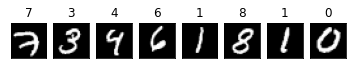

Target domain : MNIST-M


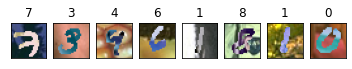

In [2]:
mnist = MNISTdata()
data_S = mnist.getTask()
mnistm = MNIST_Mdata()
data_T = mnistm.getTask()

print("\n\nSource domain : MNIST")
showSamples(data_S['x_train'], data_S['y_train'], 1, 8)
print("Target domain : MNIST-M")
showSamples(data_T['x_train'], data_T['y_train'], 1, 8)

### Model (Non-adpated)

The next step is building a classifier and feed the source dataset to it.

Run the following cells to train your model for 100 epochs .

Epoch 10:
  └LOSS: label (0.018)
  └ACC: label (S : 0.991/ T : 0.475), domain (S : 0.371/ T : 0.480)
Epoch 20:
  └LOSS: label (0.008)
  └ACC: label (S : 0.991/ T : 0.473), domain (S : 0.410/ T : 0.686)
Epoch 30:
  └LOSS: label (0.006)
  └ACC: label (S : 0.992/ T : 0.478), domain (S : 0.440/ T : 0.604)
Epoch 40:
  └LOSS: label (0.006)
  └ACC: label (S : 0.992/ T : 0.489), domain (S : 0.446/ T : 0.673)
Epoch 50:
  └LOSS: label (0.003)
  └ACC: label (S : 0.989/ T : 0.481), domain (S : 0.360/ T : 0.844)
Epoch 60:
  └LOSS: label (0.004)
  └ACC: label (S : 0.992/ T : 0.517), domain (S : 0.404/ T : 0.767)
Epoch 70:
  └LOSS: label (0.003)
  └ACC: label (S : 0.992/ T : 0.467), domain (S : 0.357/ T : 0.838)
Epoch 80:
  └LOSS: label (0.001)
  └ACC: label (S : 0.992/ T : 0.471), domain (S : 0.280/ T : 0.814)
Epoch 90:
  └LOSS: label (0.002)
  └ACC: label (S : 0.990/ T : 0.482), domain (S : 0.262/ T : 0.850)
Epoch 100:
  └LOSS: label (0.002)
  └ACC: label (S : 0.993/ T : 0.469), domain (S : 0.382/ 

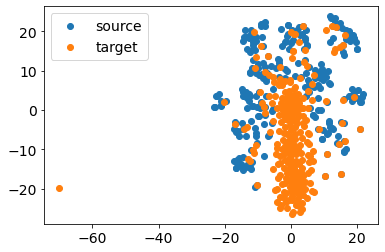

In [3]:
M = Model()
        
M.train(data_S, data_T, trainingMode='source only')

Epoch 10:
  └LOSS: label (0.090)
  └ACC: label (S : 0.983/ T : 0.957), domain (S : 0.291/ T : 0.690)
Epoch 20:
  └LOSS: label (0.035)
  └ACC: label (S : 0.982/ T : 0.967), domain (S : 0.368/ T : 0.622)
Epoch 30:
  └LOSS: label (0.022)
  └ACC: label (S : 0.983/ T : 0.967), domain (S : 0.291/ T : 0.626)
Epoch 40:
  └LOSS: label (0.021)
  └ACC: label (S : 0.984/ T : 0.967), domain (S : 0.382/ T : 0.525)
Epoch 50:
  └LOSS: label (0.010)
  └ACC: label (S : 0.983/ T : 0.965), domain (S : 0.296/ T : 0.607)
Epoch 60:
  └LOSS: label (0.013)
  └ACC: label (S : 0.981/ T : 0.964), domain (S : 0.363/ T : 0.592)
Epoch 70:
  └LOSS: label (0.009)
  └ACC: label (S : 0.984/ T : 0.968), domain (S : 0.414/ T : 0.547)
Epoch 80:
  └LOSS: label (0.011)
  └ACC: label (S : 0.984/ T : 0.970), domain (S : 0.442/ T : 0.560)
Epoch 90:
  └LOSS: label (0.009)
  └ACC: label (S : 0.985/ T : 0.965), domain (S : 0.516/ T : 0.482)
Epoch 100:
  └LOSS: label (0.011)
  └ACC: label (S : 0.986/ T : 0.966), domain (S : 0.419/ 

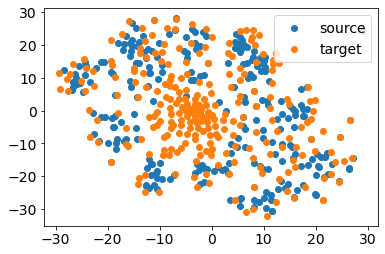

In [4]:
M.train(data_S, data_T, trainingMode='target only')

### Model (Adpated)

Finally you will train the DANN model. 

Epoch 10:
  └LOSS: total (0.697), domain (0.605), label (0.093)
  └ACC: label (S : 0.976/ T : 0.696), domain (S : 0.756/ T : 0.543)
Epoch 20:
  └LOSS: total (0.640), domain (0.575), label (0.065)
  └ACC: label (S : 0.978/ T : 0.678), domain (S : 0.770/ T : 0.701)
Epoch 30:
  └LOSS: total (0.660), domain (0.607), label (0.053)
  └ACC: label (S : 0.978/ T : 0.710), domain (S : 0.797/ T : 0.508)
Epoch 40:
  └LOSS: total (0.654), domain (0.605), label (0.049)
  └ACC: label (S : 0.983/ T : 0.743), domain (S : 0.806/ T : 0.486)
Epoch 50:
  └LOSS: total (0.678), domain (0.636), label (0.041)
  └ACC: label (S : 0.979/ T : 0.753), domain (S : 0.746/ T : 0.547)
Epoch 60:
  └LOSS: total (0.656), domain (0.620), label (0.036)
  └ACC: label (S : 0.976/ T : 0.760), domain (S : 0.752/ T : 0.520)
Epoch 70:
  └LOSS: total (0.672), domain (0.633), label (0.038)
  └ACC: label (S : 0.982/ T : 0.768), domain (S : 0.755/ T : 0.552)
Epoch 80:
  └LOSS: total (0.675), domain (0.641), label (0.034)
  └ACC: labe

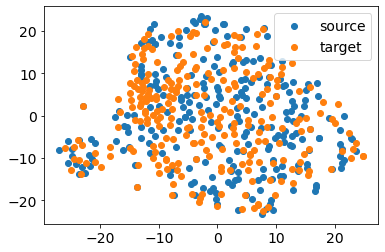

In [5]:
M.train(data_S, data_T, trainingMode='dann')